<h1>Question 3.1: Visualizing intermediate activations</h1>
Author: ruhei08
<h3>Start by loading ind some data</h3>

In [1]:
import os
from natsort import natsorted
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten,Conv2D,Input,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from natsort import natsorted

def image_files():
    # Read filenames of all files in the data directory
    list_files = os.listdir('./DIDA_1')
    # Sort filenames to make sure they are in the same order as the labels
    list_files = natsorted(list_files) 
    return list_files


def load_images(filepaths):
    images = []
    for i in range(len(filepaths)):
        # Resize images to be (100, 150, 1)
        img = image.load_img("DIDA_1/"+filepaths[i], target_size=(100,150,1), color_mode="grayscale")
        img = image.img_to_array(img)
        img.astype('float32')
        # Rescale to make all pixel values between 0 and 1
        img = img/255
        images.append(img)
    images = np.array(images)
    return images


# Loading, resizing and rescaling the images
filepaths = image_files()
X = load_images(filepaths)


# Loading the targets
targets = pd.read_csv('CC_D_Y_labels.csv')
y_cc = targets.CC.to_numpy()
y_d = targets.D.replace(10,5).to_numpy()    # Keras only works if there is no "gap" in the labels
y_y = targets.Y.to_numpy()

X_train, X_test, y_train_d, y_test_d = train_test_split(X, y_d, test_size=0.2, shuffle=True, stratify=y_d)

<h3>Load the model we want to visualize from</h3>

In [2]:
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomContrast
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, SpatialDropout2D, Input, BatchNormalization, Add, Flatten
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomContrast
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_model(units_out):
    BLOCK_DEPTH = 3
    SPATIAL_DROPOUT_RATE = 0.08
    
    data_augmentation = Sequential([
                    RandomRotation(0.04),
                    RandomContrast(0.1),
                    RandomTranslation(width_factor=0.05, height_factor=0.05),
                ])
    
    inp = Input(shape=(100,150,1))
    x = data_augmentation(inp)
    for filters in [32,64,64,128]:
        x = Conv2D(filters, kernel_size=(3,3), activation="relu", use_bias =False)(x)
        skip = x
        x = BatchNormalization()(x)
        x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        for _ in range(BLOCK_DEPTH):
            x = Conv2D(filters, kernel_size=(3,3), activation="relu", use_bias =False, padding="same")(x)
            x = BatchNormalization()(x)
            x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        x = Add()([x,skip])
        x = BatchNormalization()(x)
        x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128,activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(units_out,activation="softmax")(x)
    return Model(inp, out)

modelC = build_model(2)
#modelC.summary()

optimizer = Adam(learning_rate = 1e-3)

modelC.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

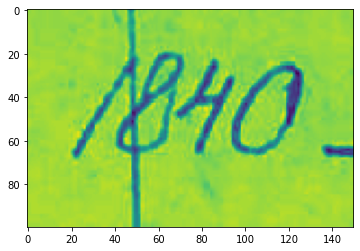

In [3]:
# Load the example images, that we want to do feature map activations on.
example_image = X[0:3].copy()
plt.imshow(example_image[2])

<h1> ModelCC - feature map activation</h1>


In [4]:
#Load the model-weights.
modelC.load_weights("Models/res_CC_w.h5")

In [5]:
modelC.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 100, 150, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 148, 32)  288         ['sequential[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 98, 148, 32)  128        ['conv2d[0][0]']             

<h3>Define activation model with outputs from layers</h3>

In [21]:
from keras import models
layer_outputs = [layer.output for layer in modelC.layers[0:1]]
activation_model = models.Model(inputs=modelC.input, outputs=layer_outputs)
activation = activation_model.predict(example_image)

In [27]:
#Pick an existing layername(Changes every time you load a model. So update this name.)
layers_name = ['conv2d_3']
outputs = [
    layer.output for layer in modelC.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(modelC.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='binary_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array(example_image))

(98, 148, 32)


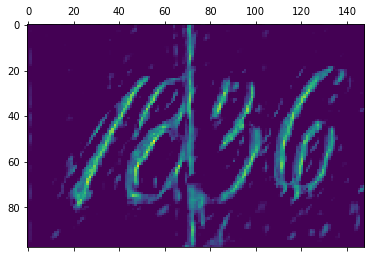

In [28]:
#Example on one channel
first_layer_activations = activations_1[0]
print(first_layer_activations.shape)
plt.matshow(first_layer_activations[:, :, 2])

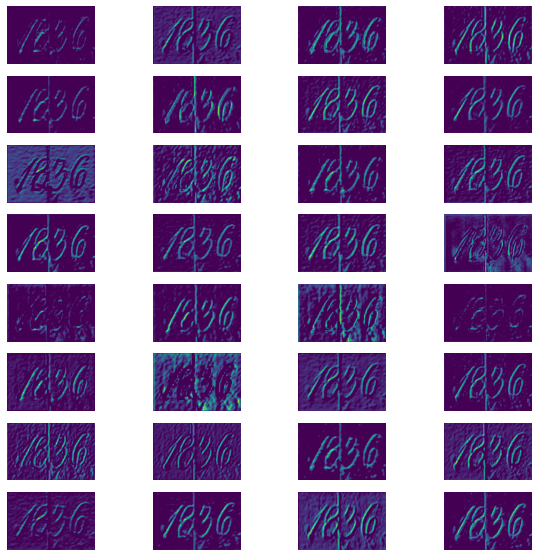

In [29]:
#plot all channels
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1); 
    plt.axis('off'); 
    plt.imshow(first_layer_activations[:, :, i])

<h1> ModelD - feature maps the same procedure the first time</h1>


In [30]:
modelD = build_model(6)
optimizer = Adam(learning_rate = 1e-3)
modelD.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
modelD.load_weights("Models/res_D.h5")
modelD.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 100, 150, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 98, 148, 32)  288         ['sequential_1[0][0]']           
                                                                                                  
 batch_normalization_20 (BatchN  (None, 98, 148, 32)  128        ['conv2d_16[0][0]']       

In [31]:
from keras import models
layer_outputs = [layer.output for layer in modelD.layers[0:1]]
activation_model = models.Model(inputs=modelD.input, outputs=layer_outputs)
activation = activation_model.predict(example_image)

In [42]:
#Pick an existing layername(Changes every time you load a model. So update this name.)
layers_name = ['conv2d_31']
outputs = [
    layer.output for layer in modelD.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(modelD.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='spare_categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array(example_image))


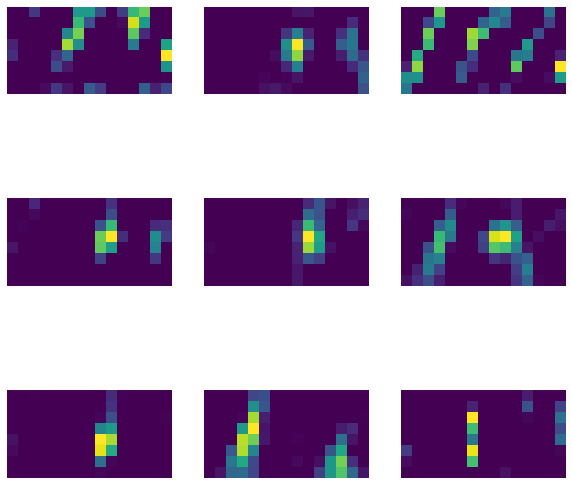

In [43]:
#plot all channels
first_layer_activations = activations_1[0]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); 
    plt.axis('off'); 
    plt.imshow(first_layer_activations[:, :, i])

<h1> ModelD - feature maps the same procedure the first time</h1>


In [54]:
modelY = build_model(11)
optimizer = Adam(learning_rate = 1e-3)
modelY.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
modelY.load_weights("Models/res_Y.h5")

layer_outputs = [layer.output for layer in modelY.layers[0:1]]
activation_model = models.Model(inputs=modelY.input, outputs=layer_outputs)
activation = activation_model.predict(example_image)

modelY.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 100, 150, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 98, 148, 32)  288         ['sequential_3[0][0]']           
                                                                                                  
 batch_normalization_60 (BatchN  (None, 98, 148, 32)  128        ['conv2d_48[0][0]']       

In [55]:
#Pick an existing layername(Changes every time you load a model. So update this name.)
layers_name = ['conv2d_63']
outputs = [
    layer.output for layer in modelY.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(modelY.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='spare_categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array(example_image))


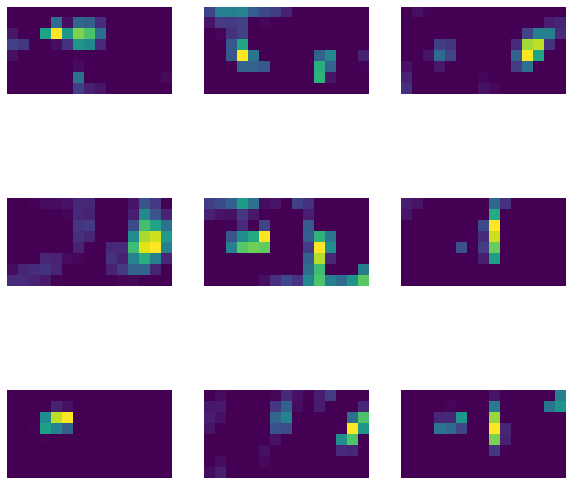

In [57]:
#plot all channels
first_layer_activations = activations_1[0]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3,3, i + 1); 
    plt.axis('off'); 
    plt.imshow(first_layer_activations[:, :, i])